In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Function to read the data
def read_data(filename):
    data = pd.read_csv(filename, header=None)
    features = data.iloc[:, :-1].values
    labels = data.iloc[:, -1].values - 1  # Shift the class labels to 0-25
    return features, labels

# Read the data
data_url = "https://raw.githubusercontent.com/UMBInal/data/main/data.csv"
x, y = read_data(data_url)

In [4]:
# Split the data into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [5]:
# Reshape the data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [6]:
# Determine the input shape and number of classes
input_shape = (x_train.shape[1], 1)
num_classes = len(np.unique(y))

In [7]:
# Transformer Encoder function with dropout and L2 regularization
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1, l2_reg=0.01):
    
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed-forward network with dropout and L2 regularization
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(res)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(inputs.shape[-1], activation = 'softmax')(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x + res

In [8]:
# Transformer Decoder function
def transformer_decoder(inputs, enc_outputs, head_size, num_heads, ff_dim, dropout=0.1, l2_reg=0.01):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(res, enc_outputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = x + res

    # Feed-forward network
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(inputs.shape[-1], activation = 'softmax')(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x + res


In [9]:
# Build the model
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0, l2_reg=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Encoder
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_reg)

        
    # Decoder
    decoder_input = keras.Input(shape=input_shape)
    dec = decoder_input
    for _ in range(num_transformer_blocks):
        dec = transformer_decoder(dec, x, head_size, num_heads, ff_dim, dropout, l2_reg)

    x = layers.Flatten()(x)
    dec = layers.Flatten()(dec)
    x = layers.Concatenate()([x, dec])

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model([inputs, decoder_input], outputs)
    return model

In [10]:
# Define the hyperparameters

head_size = 2
num_heads = 16
ff_dim = 1024
num_transformer_blocks = 6
mlp_units = [1024]
dropout = 0.1
mlp_dropout = 0.1
initial_lr = 0.001
l2_reg=0.01

In [11]:
# Build the model
model = build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)

In [12]:
# Create the optimizer with the initial learning rate
optimizer = Adam(learning_rate=initial_lr)

In [13]:
# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [14]:
# Create the ReduceLROnPlateau callback
lr_callback = ReduceLROnPlateau(factor=0.1, patience=50)

In [15]:
# Record the start time
start_time = time.time()

In [16]:
model.fit([x_train, x_train], y_train,
          batch_size=64,
          epochs=400,
          validation_data=([x_val, x_val], y_val),
          callbacks=[lr_callback])

Epoch 1/400
413/413 [==============================] - 170s 367ms/step - loss: 1.4583 - accuracy: 0.5521 - val_loss: 1.2279 - val_accuracy: 0.6073 - lr: 0.0010
Epoch 2/400
413/413 [==============================] - 146s 354ms/step - loss: 1.1965 - accuracy: 0.6018 - val_loss: 1.1270 - val_accuracy: 0.6220 - lr: 0.0010
Epoch 3/400
413/413 [==============================] - 150s 362ms/step - loss: 1.1313 - accuracy: 0.6163 - val_loss: 1.0863 - val_accuracy: 0.6334 - lr: 0.0010
Epoch 4/400
413/413 [==============================] - 150s 363ms/step - loss: 1.0854 - accuracy: 0.6317 - val_loss: 1.0460 - val_accuracy: 0.6381 - lr: 0.0010
Epoch 5/400
413/413 [==============================] - 145s 352ms/step - loss: 1.0496 - accuracy: 0.6378 - val_loss: 1.0116 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 6/400
413/413 [==============================] - 116s 281ms/step - loss: 1.0158 - accuracy: 0.6475 - val_loss: 0.9846 - val_accuracy: 0.6622 - lr: 0.0010
Epoch 7/400
413/413 [===================

Epoch 52/400
413/413 [==============================] - 114s 277ms/step - loss: 0.5259 - accuracy: 0.8147 - val_loss: 0.4802 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 53/400
413/413 [==============================] - 113s 274ms/step - loss: 0.5198 - accuracy: 0.8157 - val_loss: 0.4784 - val_accuracy: 0.8394 - lr: 0.0010
Epoch 54/400
413/413 [==============================] - 113s 274ms/step - loss: 0.5154 - accuracy: 0.8166 - val_loss: 0.4759 - val_accuracy: 0.8341 - lr: 0.0010
Epoch 55/400
413/413 [==============================] - 115s 279ms/step - loss: 0.5123 - accuracy: 0.8195 - val_loss: 0.4879 - val_accuracy: 0.8329 - lr: 0.0010
Epoch 56/400
413/413 [==============================] - 117s 282ms/step - loss: 0.5101 - accuracy: 0.8188 - val_loss: 0.4806 - val_accuracy: 0.8374 - lr: 0.0010
Epoch 57/400
413/413 [==============================] - 117s 284ms/step - loss: 0.5037 - accuracy: 0.8217 - val_loss: 0.4667 - val_accuracy: 0.8464 - lr: 0.0010
Epoch 58/400
413/413 [============

Epoch 103/400
413/413 [==============================] - 116s 280ms/step - loss: 0.4059 - accuracy: 0.8591 - val_loss: 0.3631 - val_accuracy: 0.8859 - lr: 0.0010
Epoch 104/400
413/413 [==============================] - 116s 280ms/step - loss: 0.4068 - accuracy: 0.8577 - val_loss: 0.3585 - val_accuracy: 0.8755 - lr: 0.0010
Epoch 105/400
413/413 [==============================] - 113s 274ms/step - loss: 0.4005 - accuracy: 0.8596 - val_loss: 0.3497 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 106/400
413/413 [==============================] - 116s 280ms/step - loss: 0.4052 - accuracy: 0.8568 - val_loss: 0.3532 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 107/400
413/413 [==============================] - 116s 280ms/step - loss: 0.3973 - accuracy: 0.8600 - val_loss: 0.3529 - val_accuracy: 0.8815 - lr: 0.0010
Epoch 108/400
413/413 [==============================] - 116s 281ms/step - loss: 0.3984 - accuracy: 0.8596 - val_loss: 0.3560 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 109/400
413/413 [=====

413/413 [==============================] - 115s 278ms/step - loss: 0.3582 - accuracy: 0.8723 - val_loss: 0.3155 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 154/400
413/413 [==============================] - 115s 279ms/step - loss: 0.3635 - accuracy: 0.8713 - val_loss: 0.3207 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 155/400
413/413 [==============================] - 113s 273ms/step - loss: 0.3618 - accuracy: 0.8700 - val_loss: 0.3230 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 156/400
413/413 [==============================] - 113s 273ms/step - loss: 0.3581 - accuracy: 0.8734 - val_loss: 0.3140 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 157/400
413/413 [==============================] - 115s 278ms/step - loss: 0.3596 - accuracy: 0.8719 - val_loss: 0.3102 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 158/400
413/413 [==============================] - 115s 278ms/step - loss: 0.3580 - accuracy: 0.8730 - val_loss: 0.3221 - val_accuracy: 0.8891 - lr: 0.0010
Epoch 159/400
413/413 [===================

Epoch 204/400
413/413 [==============================] - 114s 275ms/step - loss: 0.3378 - accuracy: 0.8774 - val_loss: 0.2903 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 205/400
413/413 [==============================] - 116s 280ms/step - loss: 0.3418 - accuracy: 0.8781 - val_loss: 0.2871 - val_accuracy: 0.8996 - lr: 0.0010
Epoch 206/400
413/413 [==============================] - 115s 279ms/step - loss: 0.3364 - accuracy: 0.8793 - val_loss: 0.2898 - val_accuracy: 0.9024 - lr: 0.0010
Epoch 207/400
413/413 [==============================] - 115s 277ms/step - loss: 0.3316 - accuracy: 0.8813 - val_loss: 0.3057 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 208/400
413/413 [==============================] - 113s 273ms/step - loss: 0.3410 - accuracy: 0.8780 - val_loss: 0.3035 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 209/400
413/413 [==============================] - 113s 274ms/step - loss: 0.3382 - accuracy: 0.8768 - val_loss: 0.2866 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 210/400
413/413 [=====

413/413 [==============================] - 116s 280ms/step - loss: 0.3240 - accuracy: 0.8828 - val_loss: 0.2770 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 255/400
413/413 [==============================] - 118s 286ms/step - loss: 0.3245 - accuracy: 0.8813 - val_loss: 0.2863 - val_accuracy: 0.9015 - lr: 0.0010
Epoch 256/400
413/413 [==============================] - 116s 280ms/step - loss: 0.3288 - accuracy: 0.8812 - val_loss: 0.2820 - val_accuracy: 0.8987 - lr: 0.0010
Epoch 257/400
413/413 [==============================] - 116s 281ms/step - loss: 0.3257 - accuracy: 0.8821 - val_loss: 0.2836 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 258/400
413/413 [==============================] - 116s 280ms/step - loss: 0.3214 - accuracy: 0.8822 - val_loss: 0.2813 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 259/400
413/413 [==============================] - 113s 274ms/step - loss: 0.3252 - accuracy: 0.8831 - val_loss: 0.2786 - val_accuracy: 0.9055 - lr: 0.0010
Epoch 260/400
413/413 [===================

Epoch 305/400
413/413 [==============================] - 116s 280ms/step - loss: 0.3136 - accuracy: 0.8865 - val_loss: 0.2684 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 306/400
413/413 [==============================] - 116s 280ms/step - loss: 0.3096 - accuracy: 0.8865 - val_loss: 0.2643 - val_accuracy: 0.9037 - lr: 0.0010
Epoch 307/400
413/413 [==============================] - 114s 275ms/step - loss: 0.3103 - accuracy: 0.8851 - val_loss: 0.2689 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 308/400
413/413 [==============================] - 114s 275ms/step - loss: 0.3127 - accuracy: 0.8841 - val_loss: 0.2724 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 309/400
413/413 [==============================] - 115s 279ms/step - loss: 0.3122 - accuracy: 0.8847 - val_loss: 0.2656 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 310/400
413/413 [==============================] - 118s 285ms/step - loss: 0.3141 - accuracy: 0.8848 - val_loss: 0.2743 - val_accuracy: 0.9052 - lr: 0.0010
Epoch 311/400
413/413 [=====

413/413 [==============================] - 115s 278ms/step - loss: 0.3055 - accuracy: 0.8860 - val_loss: 0.2658 - val_accuracy: 0.9102 - lr: 0.0010
Epoch 356/400
413/413 [==============================] - 114s 275ms/step - loss: 0.3043 - accuracy: 0.8896 - val_loss: 0.2763 - val_accuracy: 0.8991 - lr: 0.0010
Epoch 357/400
413/413 [==============================] - 113s 275ms/step - loss: 0.3043 - accuracy: 0.8869 - val_loss: 0.2638 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 358/400
413/413 [==============================] - 114s 275ms/step - loss: 0.3061 - accuracy: 0.8863 - val_loss: 0.2599 - val_accuracy: 0.9052 - lr: 0.0010
Epoch 359/400
413/413 [==============================] - 116s 281ms/step - loss: 0.3074 - accuracy: 0.8871 - val_loss: 0.2570 - val_accuracy: 0.9005 - lr: 0.0010
Epoch 360/400
413/413 [==============================] - 116s 281ms/step - loss: 0.3012 - accuracy: 0.8904 - val_loss: 0.2554 - val_accuracy: 0.9055 - lr: 0.0010
Epoch 361/400
413/413 [===================

In [17]:
# Record the end time
end_time = time.time()

In [18]:
# Calculate the total running time
running_time = end_time - start_time
print("Total Running Time: {:.2f} seconds".format(running_time))

Total Running Time: 48440.51 seconds


In [19]:
# Evaluate the model
loss, accuracy = model.evaluate([x_test, x_test], y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

115/115 [==============================] - 8s 66ms/step - loss: 0.2531 - accuracy: 0.9073
Test loss: 0.253093421459198, Test accuracy: 0.9072811603546143


In [20]:
# Evaluate the model
y_pred = model.predict([x_test, x_test])
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

115/115 [==============================] - 11s 65ms/step


In [21]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

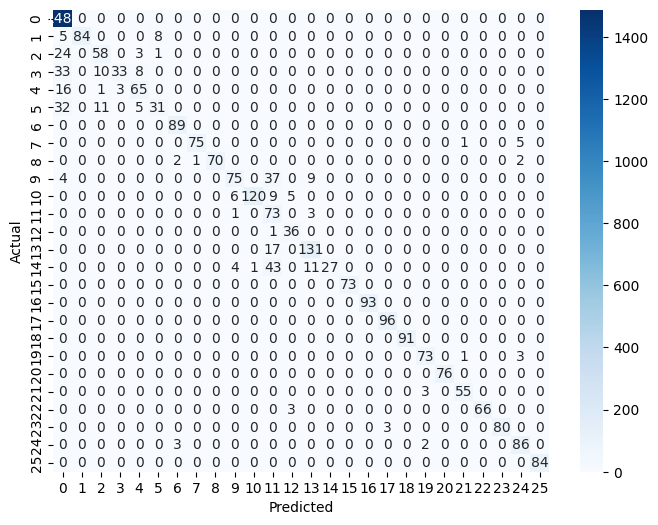

In [22]:
# Plot the confusion matrix
class_names = np.unique(y)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [23]:
# Save the trained model
model.save("my_model_25.h5")